In [1]:
import torch
import torch.nn as nn
import os 
import pandas as pd
from torchvision import transforms, datasets
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
from PIL import Image
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from torchsummary import summary
ROOT_DATA_DIR = "/workspace/resnet/data/raw"
DATA_DIR = os.path.join(ROOT_DATA_DIR)#, "labelme-12-50k")
CLASSES_TXT_PATH = os.path.join(DATA_DIR, "classes.txt")


num_classes = 12
learning_rate = 0.001
num_epochs = 3
batch_size = 64
patience = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open(CLASSES_TXT_PATH) as file:
    class_map_s2i = {line.rstrip():i for i, line in enumerate(file.readlines()) if line.rstrip()}
class_map_i2s = {v:k for k,v in class_map_s2i.items()}

INTERIM_DATA_DIR = "/workspace/resnet/data/interim/"

ROOT_DIR = "/workspace/resnet/"
MODEL_DIR = os.path.join(ROOT_DIR, "models")
CNN_PATH = os.path.join(MODEL_DIR, "2.2_resnet-balanced")

In [2]:
class_map_i2s

{0: 'person',
 1: 'car',
 2: 'building',
 3: 'window',
 4: 'tree',
 5: 'sign',
 6: 'door',
 7: 'bookshelf',
 8: 'chair',
 9: 'table',
 10: 'keyboard',
 11: 'head'}

In [3]:
train_df_balanced = pd.read_csv(os.path.join(INTERIM_DATA_DIR,"balanced-train-40000.csv"))
test_df = pd.read_csv(os.path.join(INTERIM_DATA_DIR,"test-10000.csv"))

In [4]:
transform = transforms.Compose(
            [transforms.ToTensor()
             ,transforms.Normalize((0.5,0.5,0.5),(0.5, 0.5, 0.5))
            ]
            )

In [5]:
class MyDataset(Dataset):
    def __init__(self,annot_df,transform = None):
        self.annotations = annot_df
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        img = Image.open(self.annotations.img_path[index])
        y_label = torch.tensor(int(self.annotations.int_label[index]))
        if self.transform:
            image = transform(img)
        else:
            image = img
        return (image,y_label)

In [6]:
# train_data = MyDataset(train_df,transform = transform)
test_data = MyDataset(test_df,transform = transform)
train_data_balanced = MyDataset(train_df_balanced,transform = transform)


# train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)
train_loader_balanced = DataLoader(dataset = train_data_balanced, batch_size = batch_size, shuffle = True)

test_loader

In [7]:
model = resnet18(pretrained=True)

n_feats = model.fc.in_features
model.fc = nn.Linear(n_feats, 12)
# model = CNN(12)
model.load_state_dict(torch.load(CNN_PATH))
model.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
summary(model,(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

tensor(3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTION: window
ACTUAL: window


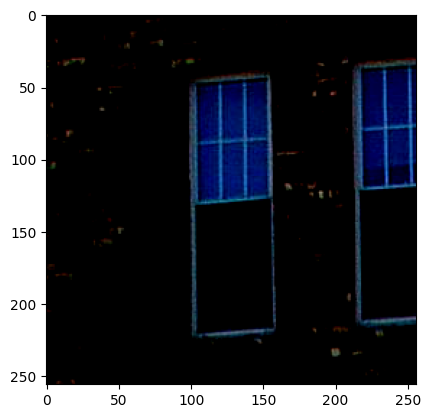

In [16]:
torch_test_df = test_loader.dataset #test_loader.dataset
torch_test_df = train_loader_balanced.dataset #test_loader.dataset

n_samples = len(torch_test_df)



# Get a random sample
random_index = int(np.random.random()*n_samples)
# single_example = torch_test_df[random_index]
# single_example = torch_test_df.sample(64)

# label, image = next(iter(single_example))
# Image.open(image)
# print(class_map_i2s[int(single_example[1].numpy())])
# plt.imshow(single_example[0].permute(1, 2, 0))
import numpy as np
your_list = list(np.random.permutation(np.arange(0,len(torch_test_df)))[:64])
trainset_1 = torch.utils.data.Subset(torch_test_df, your_list)
(trainset_1[63][0].shape)
images = torch.stack([i[0] for i in trainset_1])#.shape
labels = torch.stack([i[1] for i in trainset_1])
print(labels[0])
type(images)
images = images
# plt.imshow(transforms.ToPILImage()(images))#, interpolation="bicubic")
with torch.no_grad():
#     images = images.to(device)
#     print(images.shape)
    outputs = model((images))#model(images)
#     print(torch.max(outputs.data,1)[0])
#     print(.shape)
    #[0][0])
    plt.imshow(images[0].permute(1, 2, 0))
    print(f'PREDICTION: {class_map_i2s[int(torch.argmax(outputs.data,1)[0].int())]}')
    print(f'ACTUAL: {class_map_i2s[int(labels[0])]}')
    
    

# single_example[0]

In [10]:
stop

NameError: name 'stop' is not defined

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
#         print(type(images))
#         print(images.shape)
#         print(images)
        outputs = model(images)
#         print(outputs)
        _, predicted = torch.max(outputs.data, 1)
#         print(predicted)
#         print(labels)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(labels.size(0))
        print((predicted == labels).sum().item())
        print("-------------------")
        end
    
    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))




In [ ]:
predicted[0]

In [ ]:
labels[0]

In [ ]:
images[0]

In [ ]:
plt.imshow(transforms.ToPILImage()(images[0]), interpolation="bicubic")

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
images

In [ ]:
torch_test_df = test_loader.dataset
n_samples = len(torch_test_df)

# Get a random sample
random_index = int(np.random.random()*n_samples)
single_example = torch_test_df[random_index]
# label, image = next(iter(single_example))
# Image.open(image)
print(class_map_i2s[int(single_example[1].numpy())])
# plt.imshow(single_example[0].permute(1, 2, 0))
plt.imshow(transforms.ToPILImage()(single_example[0]), interpolation="bicubic")
with torch.no_grad():
    images = single_example[0].to(device)
    outputs = model(images)
    print(outputs)

# single_example[0]

In [ ]:
images, labels = next(iter(test_loader))
images[1].shape